# Numerical Experiments on Time Limit Dependency of MIP Solver

In this notebook, we will conduct numerical experiments on the time limit dependency of MIP solvers using PySCIPOpt, which is supported by OMMX.
MINTO natively supports OMMX Message, allowing us to smoothly perform numerical experiments through OMMX. Let's give it a try.


In [1]:
import minto
import ommx_pyscipopt_adapter as scip_ad
from ommx.dataset import miplib2017

In this tutorial, we will pick up an instance from miplib2017 as a benchmark target. We can easily obtain miplib2017 instances using ommx.dataset.

In [2]:
instance_name = "reblock115"
instance = miplib2017(instance_name)

Using the ommx_pyscipopt_adapter, we convert ommx.v1.Instance to PySCIPOpt's Model and conduct experiments by varying the limits/time parameter.

The ommx instance and solution can be saved using MINTO's `.log_*` methods. Since we're using a single instance that doesn't change throughout this numerical experiment, we store it in the `experiment` space outside the with block. 
Solutions are saved within the with block (in the `run` space) since they vary for each time limit.

In [3]:
timelimit_list = [0.1, 0.5, 1, 2]


experiment = minto.Experiment(auto_saving=False)

experiment.log_instance(instance_name, instance)
adapter = scip_ad.OMMXPySCIPOptAdapter(instance)
scip_model = adapter.solver_input

for timelimit in timelimit_list:
    with experiment.run():
        experiment.log_parameter("timelimit", timelimit)

        # Solve by SCIP
        scip_model.setParam("limits/time", timelimit)
        scip_model.optimize()
        solution = adapter.decode(scip_model)

        experiment.log_solution("scip", solution)


When converting ommx.Solution to pandas.DataFrame using the `.get_run_table` method, only the main information of the solution is displayed. If you want to access the actual solution objects, you can reference them from `experiment.dataspaces.run_datastores[run_id].solutions`.

In [4]:
runs_table = experiment.get_run_table()
runs_table

solution_scip                                            parameter  \
           objective feasible optimality relaxation start  name timelimit   
run_id                                                                      
0       0.000000e+00     True          0          0  None  scip       0.1   
1      -2.824191e+07     True          0          0  None  scip       0.5   
2      -2.824191e+07     True          0          0  None  scip       1.0   
3      -2.824191e+07     True          0          0  None  scip       2.0   

       metadata               
         run_id elapsed_time  
run_id                        
0             0     0.106656  
1             1     0.407615  
2             2     0.505631  
3             3     1.006043

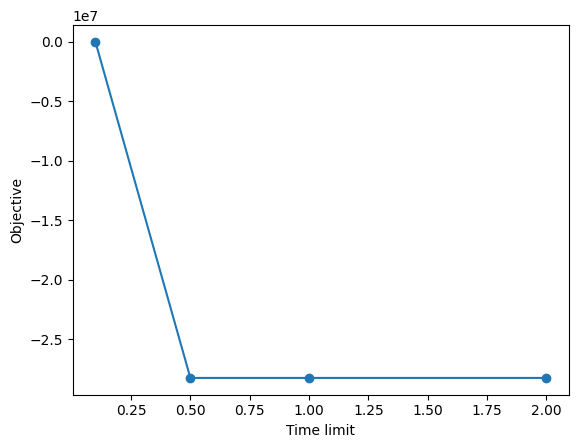

In [6]:
import matplotlib.pyplot as plt

x = runs_table["parameter", "timelimit"]
y = runs_table["solution_scip", "objective"]
plt.plot(x, y, "o-")
plt.xlabel("Time limit")
plt.ylabel("Objective")
plt.show()

As MINTO natively supports OMMX, only the main quantities are displayed when shown in a pandas.DataFrame, making it easy to perform statistical analysis.